In [1]:
%load_ext watermark


In [2]:
from collections import defaultdict
import itertools as it

import alifedata_phyloinformatics_convert as apc
from hstrat import _auxiliary_lib as hstrat_aux
from IPython.core.display import display, HTML
from matplotlib import patches as mpl_patches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp

from pylib._cv_infection_log_to_alstd_df import cv_infection_log_to_alstd_df
from pylib._draw_biophylo import draw_biophylo
from pylib._generate_dummy_sequences_phastSim import (
    generate_dummy_sequences_phastSim,
)
from pylib._make_cv_sim_uk import make_cv_sim_uk
from pylib._make_flavored_variants import make_flavored_variants
from pylib._make_variant_flavors import make_variant_flavors
from pylib._make_wt_specs_uk import make_wt_specs_uk
from pylib._mask_mutations import mask_mutations
from pylib._mwu_kdeplot import mwu_kdeplot
from pylib._screen_mutation_defined_nodes import screen_mutation_defined_nodes
from pylib._seed_global_rngs import seed_global_rngs
from pylib._SyncHostCompartments import SyncHostCompartments


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-04-25T17:35:34.214159+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1026-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

alifedata_phyloinformatics_convert: 0.19.3
scipy                             : 1.14.1
pandas                            : 2.2.3
matplotlib                        : 3.9.2
seaborn                           : 0.13.2
numpy                             : 2.1.2
hstrat                            : 1.20.1
teeplot                           : 1.4.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-24-dev-simuk"
teeplot_subdir


'2025-04-24-dev-simuk'

In [5]:
seed_global_rngs(1)


## Setup CovaSim Params


In [6]:
pop_size = 100_000
mutmx_variant = defaultdict(lambda: 1)
mutmx_variant["rel_beta"] = 0.5
# rel_symp_prob
# rel_severe_prob
# rel_crit_prob
# rel_death_prob

mutmx_withinhost_r = 1.5
mutmx_active_strain_factor = 0.8
p_wt_to_mut = 0.05


In [7]:
reference_sequences = pd.read_csv("https://osf.io/hp25c/download")
sequence_lookup = dict(
    zip(
        reference_sequences["WHO Label"].values,
        # remove whitespace pollution
        # and only use first 100 characters of the sequence, for perf/memory
        reference_sequences["Aligned Sequence"]
        .str.replace(r"\s+", "", regex=True)
        .str.slice(0, 100)
        .values,
    ),
)


In [8]:
wt_specs = make_wt_specs_uk(reference_sequences=sequence_lookup)
variant_flavors = make_variant_flavors(
    wt_specs,
    mut_variant=lambda x: {
        k: v * mutmx_variant[k] for k, v in x.variant.items()
    },
    mut_withinhost_r=lambda x: (x.withinhost_r * mutmx_withinhost_r),
    mut_active_strain_factor=lambda x: (
        x.active_strain_factor * mutmx_active_strain_factor
    ),
    p_wt_to_mut=lambda __: p_wt_to_mut,
)
flavored_variants = make_flavored_variants(variant_flavors)


## Run Example Simulation


In [9]:
sim = make_cv_sim_uk(
    preinterventions=[
        SyncHostCompartments(
            variant_flavors=variant_flavors,
            pop_size=pop_size,
        ),
    ],
    variants=flavored_variants,
    pop_size=pop_size,
)
sim.run()


Initializing sim with 100000 people for 650 days
Loading location-specific data for "uk"
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Wildtype+, setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Wildtype', setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Beta+, setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Beta', setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Alpha+, setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Alpha', setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Delta+, setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 75 and variant Delta', setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 60 and variant Wildtype+, setting to 1.0
Note: No cross-immunity specified for vaccine Vaccinate 60

Sim(<no label>; 2020-01-20 to 2021-10-31; pop: 100000 hybrid; epi: 3.01888e+07⚙, 51816.2☠)

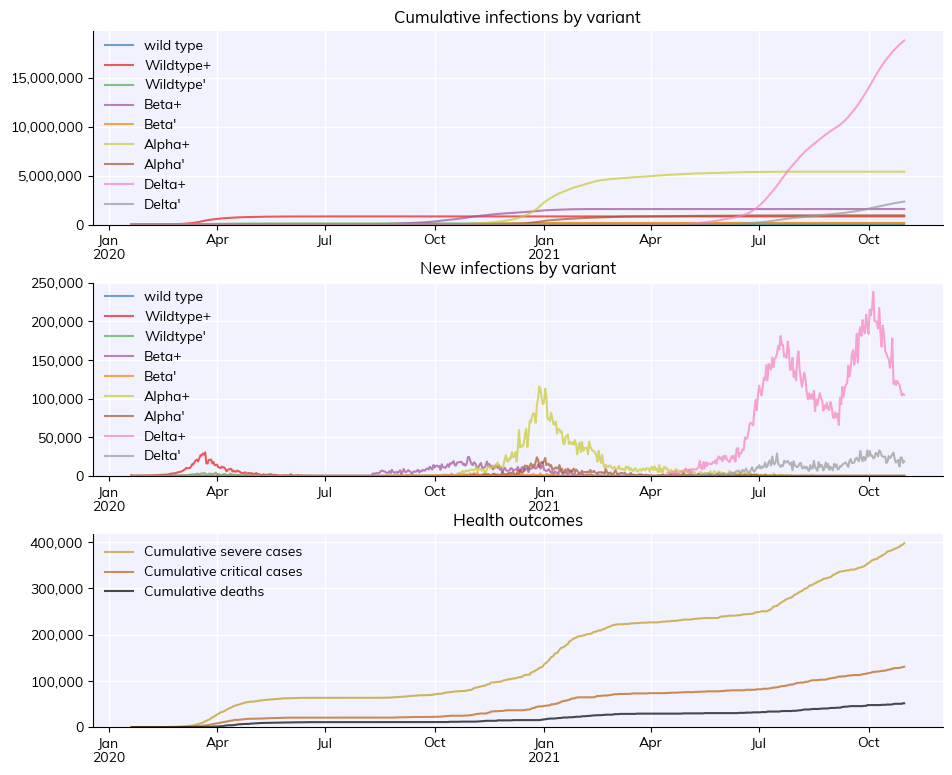

teeplots/2025-04-24-dev-simuk/viz=plot+what=within-host+ext=.pdf
teeplots/2025-04-24-dev-simuk/viz=plot+what=within-host+ext=.png


<Figure size 640x480 with 0 Axes>

Ellipsis

In [10]:
tp.tee(
    sim.plot,
    "variant",
    teeplot_outattrs={"what": "within-host"},
    teeplot_subdir=teeplot_subdir,
)
...


## Visualize Pathogen Phylogeny


In [11]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)

phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    phylo_df, n_downsample=200
)

phylo_tree = apc.alife_dataframe_to_biopython_tree(
    phylo_df,
    setattrs=["variant"],
    setup_branch_lengths=True,
)

palette = sns.color_palette("Set2", n_colors=len(variant_flavors) * 2).as_hex()
palette_iter = it.cycle(palette)
node_colors = {
    variant.label: next(palette_iter)
    for vf in variant_flavors
    for variant in (vf.variant_wt, vf.variant_mut)
}
for node in phylo_tree.find_clades():
    node.color = node_colors[node.variant]


2025-04-24-dev-simuk/viz=draw-biophylo+what=within-host+ext=.pdf
2025-04-24-dev-simuk/viz=draw-biophylo+what=within-host+ext=.png


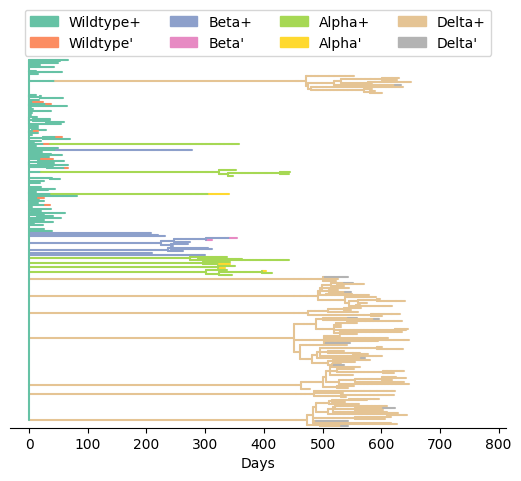

In [12]:
with tp.teed(
    draw_biophylo,
    phylo_tree,
    teeplot_outattrs={"what": "within-host"},
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in node_colors.items()
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=4,
    )


## Extract Pathogen Phylogeny Topology


In [13]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)
phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)


In [14]:
# clean tree topology
with hstrat_aux.log_context_duration(
    "alifestd_add_inner_leaves",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_add_inner_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_downsample_tips_asexual",
    logger=print,
):
    # phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    #     phylo_df,
    #     n_downsample=2_000,
    # )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_splay_polytomies",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_splay_polytomies(phylo_df, mutate=True)
    phylo_df.drop(columns=["is_leaf"], inplace=True, errors="ignore")
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_collapse_unifurcations",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_collapse_unifurcations(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_delete_unifurcating_roots_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_delete_unifurcating_roots_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

# more statistics
with hstrat_aux.log_context_duration("alifestd_mark_*", logger=print):
    phylo_df = hstrat_aux.alifestd_mark_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_sibling_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_roots(phylo_df, mutate=True)

phylo_df["is_leaf"].value_counts()


enter log_context_duration for alifestd_add_inner_leaves
exit log_context_duration for alifestd_add_inner_leaves
!!! {"alifestd_add_inner_leaves": 0.02094578742980957}
enter log_context_duration for alifestd_downsample_tips_asexual
exit log_context_duration for alifestd_downsample_tips_asexual
!!! {"alifestd_downsample_tips_asexual": 0.00029206275939941406}
enter log_context_duration for alifestd_splay_polytomies
exit log_context_duration for alifestd_splay_polytomies
!!! {"alifestd_splay_polytomies": 3.192993402481079}
enter log_context_duration for alifestd_collapse_unifurcations
exit log_context_duration for alifestd_collapse_unifurcations
!!! {"alifestd_collapse_unifurcations": 0.08157801628112793}
enter log_context_duration for alifestd_delete_unifurcating_roots_asexual
exit log_context_duration for alifestd_delete_unifurcating_roots_asexual
!!! {"alifestd_delete_unifurcating_roots_asexual": 0.06648063659667969}
enter log_context_duration for alifestd_mark_*
exit log_context_durat

is_leaf
True     84627
False    84626
Name: count, dtype: int64

## Compute Sister Statistics


In [15]:
min_leaves = 4
work_mask = (phylo_df["num_leaves"] > min_leaves) & (
    phylo_df["num_leaves_sibling"] > min_leaves
)
# sister statistics
with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_subtended_duration_ratio_sister_asexual",
    logger=print,
):
    phylo_df = (
        hstrat_aux.alifestd_mark_clade_subtended_duration_ratio_sister_asexual(
            phylo_df, mutate=True
        )
    )
    phylo_df["clade duration ratio"] = np.log(
        phylo_df["clade_subtended_duration_ratio_sister"]
    )

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_logistic_growth_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_logistic_growth_sister_asexual(
        phylo_df, mutate=True, parallel_backend="loky", work_mask=work_mask
    )
    phylo_df["clade growth ratio"] = phylo_df["clade_logistic_growth_sister"]

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_leafcount_ratio_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_leafcount_ratio_sister_asexual(
        phylo_df, mutate=True
    )
    phylo_df["clade size ratio"] = np.log(
        phylo_df["clade_leafcount_ratio_sister"],
    )


enter log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual
!!! {"alifestd_mark_clade_subtended_duration_ratio_sister_asexual": 0.13389205932617188}
enter log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual


/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_alifestd_mark_clade_subtended_duration_ratio_sister_asexual.py:52: RuntimeWarning: divide by zero encountered in divide
  phylogeny_df["clade_subtended_duration"].values
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:

exit log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual
!!! {"alifestd_mark_clade_logistic_growth_sister_asexual": 122.88825058937073}
enter log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
!!! {"alifestd_mark_clade_leafcount_ratio_sister_asexual": 0.035631418228149414}


## Generate Pathogen Dummy Sequences


In [16]:
# strip whtiespace
phylo_df.reset_index(drop=True, inplace=True)

phylo_df["variant_flavor"] = phylo_df["variant"].map(
    {
        v.label: vf.label
        for vf in variant_flavors
        for v in (vf.variant_mut, vf.variant_wt)
    },
)
# root (topologically sorted)
ancestral_variant_flavor = phylo_df.at[0, "variant_flavor"]
ancestral_sequence = sequence_lookup[ancestral_variant_flavor]

dummy_sequences = generate_dummy_sequences_phastSim(
    phylo_df,
    ancestral_sequences=sequence_lookup,
)
dummy_sequences["variant"] = dummy_sequences["id"].map(
    phylo_df.set_index("id")["variant"].to_dict(),
)

ancestral_sequence = "A" + ancestral_sequence
dummy_sequences["sequence"] = (
    dummy_sequences["variant"]
    .str.contains("'")
    .map(
        {
            True: "X",
            False: "A",
        },
    )
    + dummy_sequences["sequence"]
)

display(dummy_sequences.head())



 Finished reading reference genome at /tmp/tmp9m1akkwe_phastSim/ancestral_sequence.fasta with 100 bases.
Assuming UNREST nucleotide mutation model.

 Mutation rate matrix:
[[-0.472  0.039  0.31   0.123]
 [ 0.14  -3.19   0.022  3.028]
 [ 0.747  0.113 -3.813  2.953]
 [ 0.056  0.261  0.036 -0.353]]
Using a discrete distribution for variation in rates across the genome.
[1.0]
[1.]
Hypermutation class probabilities:
[1.0]
Hypermutation class rates:
[]

 Total cumulative substitution rate per site before normalization: 566711.6788321168
enter log_context_duration for mutateBranchETEhierarchy
exit log_context_duration for mutateBranchETEhierarchy
!!! {"mutateBranchETEhierarchy": 0.08817291259765625}
enter log_context_duration for restore dashes
exit log_context_duration for restore dashes
!!! {"restore dashes": 2.1457672119140625e-06}

 Finished reading reference genome at /tmp/tmpt75u7jeu_phastSim/ancestral_sequence.fasta with 58 bases.
Assuming UNREST nucleotide mutation model.

 Mutation 

,id,sequence,variant
0,166717,AATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCG...,Wildtype+
1,116215,AATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCG...,Wildtype+
2,116214,AATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCG...,Wildtype+
3,168092,AATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCG...,Wildtype+
4,168039,AATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCG...,Wildtype+


## Extract Mutation Masks, Identify Mutaiton-Defined Clades


In [17]:
mutation_masks = mask_mutations(
    ancestral_sequence=ancestral_sequence,
    derived_sequences=dummy_sequences["sequence"],
)

# convert leaf masks to phylo masks
for k, v in mutation_masks.items():  # leaf masks
    phylo_mask = np.zeros(len(phylo_df), dtype=bool)
    phylo_mask[dummy_sequences.loc[v, "id"].values] = True
    mutation_masks[k] = phylo_mask


## Helper Functions to Visualize Screened Mutations


In [18]:
# draw screened phylogeny, color by clades
def draw_screened_phylo_color_by_clades(
    phylo_df: pd.DataFrame, *, mutation: tuple, screen_result: dict
) -> None:
    draw_df = phylo_df.copy()
    draw_df["is_defining"] = screen_result["combined"]
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df, ancestor_mask=screen_result["combined"], mutate=True
    )
    draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df["extant"] = draw_df["is_screened"]
    draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    print(f"{len(draw_df)=}")
    draw_tree = apc.alife_dataframe_to_biopython_tree(
        draw_df,
        setattrs=["variant", "is_defining"],
        setup_branch_lengths=True,
    )
    if draw_tree is None:
        print("No tree")
        return
    for node in draw_tree.find_clades():
        node.color = [
            node_colors[node.variant],
            node_colors[node.variant],
            # "magenta",
        ][node.is_defining]

    with tp.teed(
        draw_biophylo,
        draw_tree,
        label_func=lambda node: [None, "X"][node.is_defining],
        teeplot_outattrs={
            "color": "defining-mut-clades",
            "what": slugify(str(mutation)),
        },
        teeplot_outdir=teeplot_subdir,
    ) as ax:
        ax.set_xlabel("Days")
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        legend_handles = [
            mpl_patches.Patch(color=color, label=variant)
            for variant, color in node_colors.items()
        ]
        ax.legend(
            handles=legend_handles,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=4,
        )


In [19]:
# draw screened phylogeny, color by screened status
def draw_screened_phylo_color_by_screened_status(
    phylo_df: pd.DataFrame, *, mutation: tuple, screen_result: dict
) -> None:
    draw_df = phylo_df.copy()
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df,
        ancestor_mask=screen_result["combined"],
        mutate=True,
    )
    draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df,
        ancestor_mask=screen_result["combined"][draw_df["sister_id"]],
        mutate=True,
    )
    draw_df["sister_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df["extant"] = draw_df["is_screened"] | draw_df["sister_screened"]
    draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    print(f"{len(draw_df)=}")
    draw_tree = apc.alife_dataframe_to_biopython_tree(
        draw_df,
        setattrs=["is_screened", "sister_screened"],
        setup_branch_lengths=True,
    )
    if draw_tree is None:
        print("No tree")
        return

    for node in draw_tree.find_clades():
        node.color = [["black", "red"], ["blue", "green"],][
            node.is_screened
        ][node.sister_screened]

    with tp.teed(
        draw_biophylo,
        draw_tree,
        teeplot_outattrs={
            "color": "screened-sister",
            "what": slugify(str(mutation)),
        },
        teeplot_outdir=teeplot_subdir,
    ) as ax:
        ax.set_xlabel("Days")
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        legend_handles = [
            mpl_patches.Patch(color=color, label=variant)
            for variant, color in {
                "is_screened": "blue",
                "sister_screened": "red",
            }.items()
        ]
        ax.legend(
            handles=legend_handles,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=2,
        )


In [20]:
# plot distributions
def plot_screened_vs_background_distributions(
    phylo_df: pd.DataFrame, *, min_leaves: int, **kwargs: dict
) -> plt.Figure:
    data_df = phylo_df.copy()
    screen_clade_size = (data_df["num_leaves"] > min_leaves) & (
        data_df["num_leaves_sibling"] > min_leaves
    )
    data_df = data_df[screen_clade_size & ~data_df["is_root"]].copy()

    fig, axs = plt.subplots(
        nrows=2,
        ncols=4,
        figsize=(8, 3),
        gridspec_kw={"height_ratios": [0.5, 1]},
    )

    mwu_kdeplot(
        data_df,
        x="clade duration ratio",
        ax=axs[1, 0],
        legend=False,
        **kwargs,
    )

    mwu_kdeplot(
        data_df,
        x="clade growth ratio",
        ax=axs[1, 1],
        legend=False,
        **kwargs,
    )
    mwu_kdeplot(
        data_df,
        x="clade size ratio",
        ax=axs[1, 2],
        legend=False,
        **kwargs,
    )
    mwu_kdeplot(
        data_df,
        x="num_leaves",
        ax=axs[1, 3],
        legend=False,
        log_scale=(True, False),
        **kwargs,
    )
    sns.kdeplot(  # dummy to create legend
        data_df,
        x="num_leaves",
        ax=axs[0, 3],
        legend=True,
        **kwargs,
    )
    sns.move_legend(
        axs[0, 3], "upper center", bbox_to_anchor=(0.5, 1.15), ncol=2
    )
    axs[0, 3].set_ylim(-10, -10)
    axs[0, 3].set_yticklabels([])
    axs[0, 3].set_xlim(-10, -10)
    axs[0, 3].set_xticklabels([])
    axs[0, 3].set_axis_off()

    for col, var in enumerate(
        [
            "clade duration ratio",
            "clade growth ratio",
            "clade size ratio",
        ],
    ):
        data_df[var] = data_df[var] > 0
        sns.histplot(
            data_df,
            hue=var,
            y="screen",
            multiple="fill",
            ax=axs[0, col],
            discrete=True,
            legend=False,
            palette=sns.color_palette("Pastel1", n_colors=2),
        )
        # for var, number true vs number false vs 0.5
        try:
            nobs = int(data_df.loc[data_df["screen"], var].sum())
            ntrial = int(data_df.loc[data_df["screen"], var].count())

            p = scipy_stats.binomtest(nobs, ntrial, p=0.5).pvalue
            if p < 0.0001:
                p = "****"
            elif p < 0.001:
                p = "***"
            elif p < 0.01:
                p = "**"
            elif p < 0.05:
                p = "*"
            else:
                p = "ns"

        except ValueError:
            p = "nan"

        axs[0, col].set_title(
            f"n = {data_df['screen'].sum()} / {data_df['screen'].count()}\n"
            f"{nobs=} {ntrial=}\n"
            f"frac {nobs / (ntrial or 1):.2f}\n"
            f"binom p = {p}",
            fontsize=8,
        )
        axs[0, col].axvline(0.5, ls="--", color="white")
        axs[0, col].set_ylim(-0.5, 1.5)

    for row in range(2):
        for col in range(1, 4):
            axs[row, col].set_ylabel("")
            axs[row, col].set_yticklabels([])

    for col in range(4):
        axs[0, col].set_xlabel("")
        axs[0, col].set_xticklabels([])

    fig.tight_layout()

    return fig


## Process Pathogen Phylogeny Statistics


enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.21084141731262207}
fisher (array([False,  True]), array([165677,   3576]))
naive (array([False,  True]), array([164832,   4421]))
combined (array([False,  True]), array([167826,   1427]))
len(draw_df)=14796
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.png


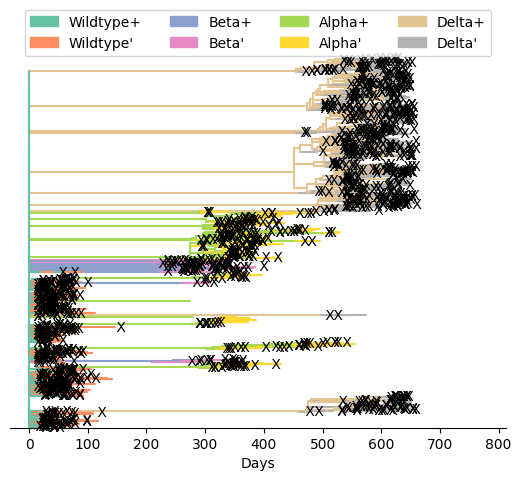

len(draw_df)=153440
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.png


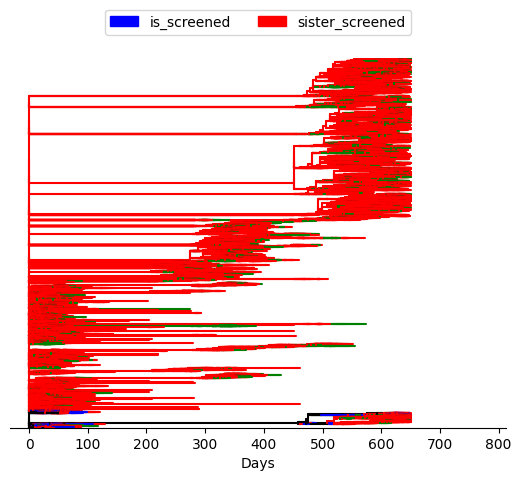

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=0-a-x+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=0-a-x+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


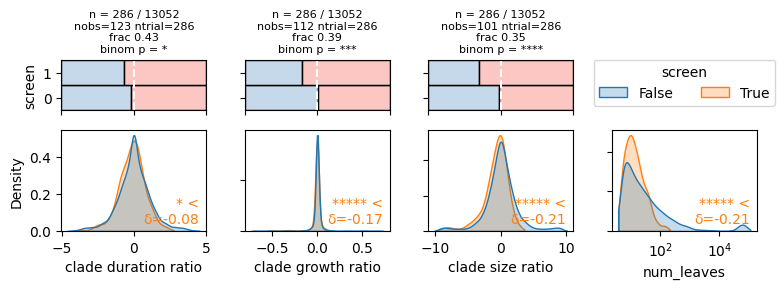

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.16411328315734863}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=1-a+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=1-a+ext=.png


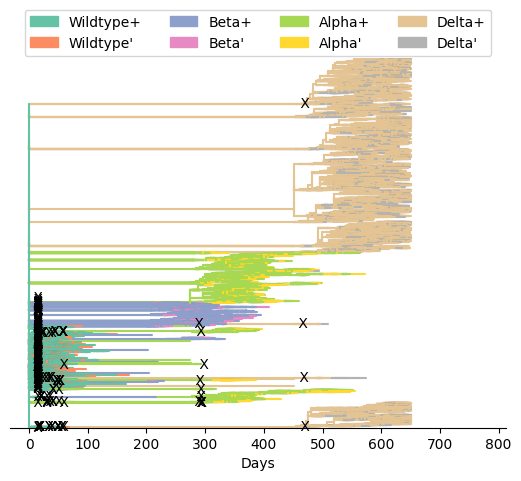

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=1-a+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=1-a+ext=.png


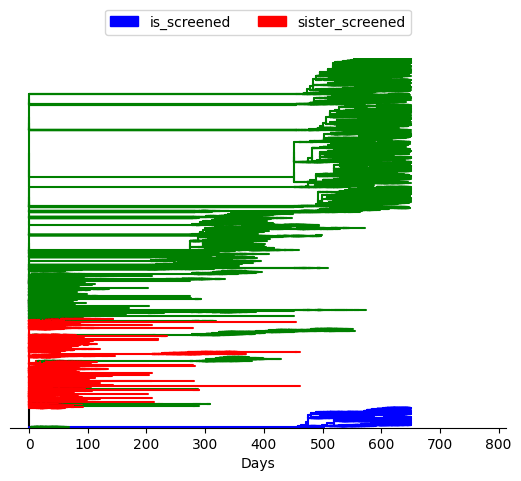

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=1-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=1-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


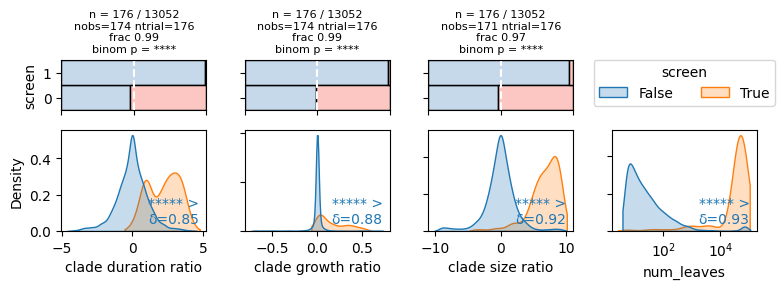

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.13850760459899902}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=2-t+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=2-t+ext=.png


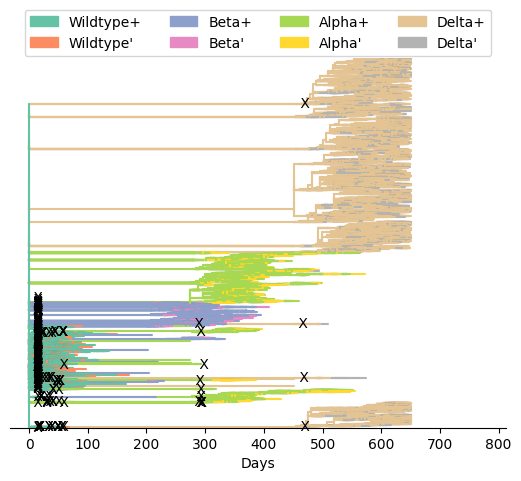

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=2-t+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=2-t+ext=.png


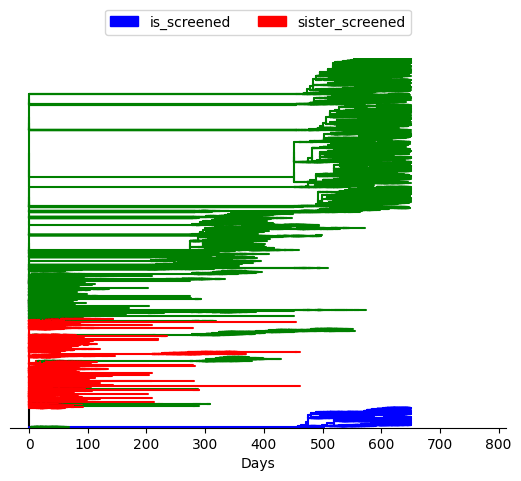

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=2-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=2-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


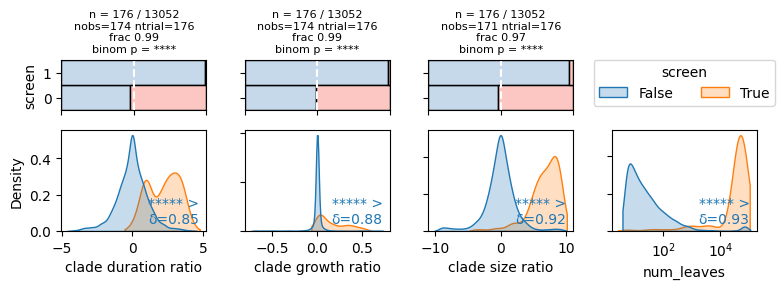

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.16736865043640137}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=3-t+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=3-t+ext=.png


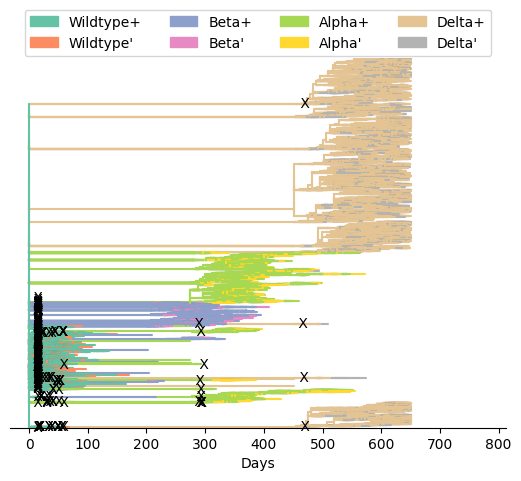

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=3-t+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=3-t+ext=.png


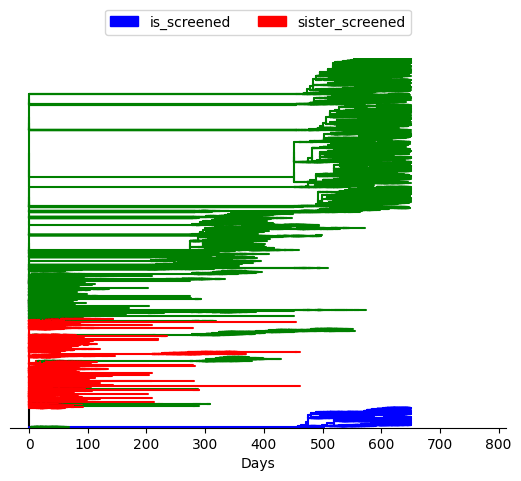

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=3-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=3-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


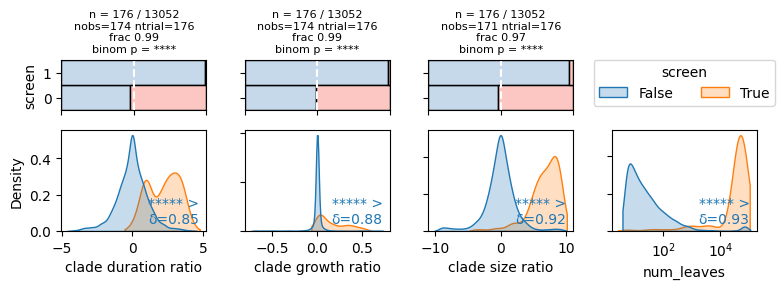

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.16982388496398926}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=4-a+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=4-a+ext=.png


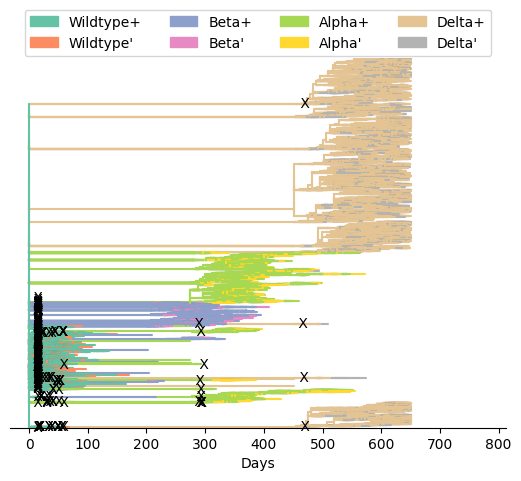

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=4-a+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=4-a+ext=.png


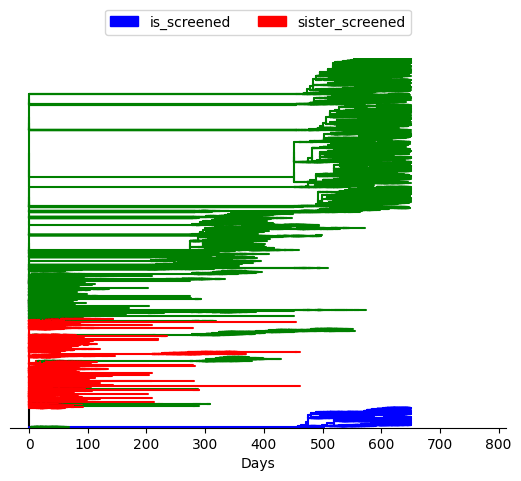

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=4-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=4-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


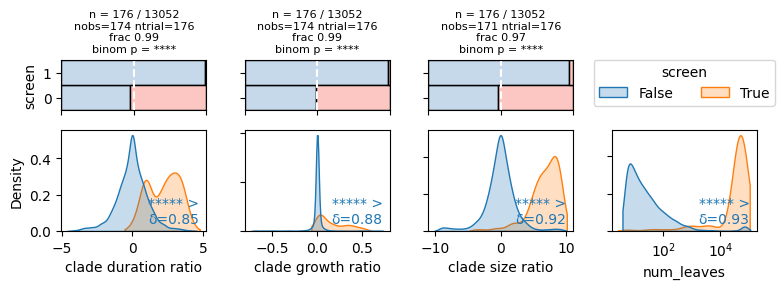

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.11508297920227051}
fisher (array([False,  True]), array([169251,      2]))
naive (array([False,  True]), array([169252,      1]))
combined (array([False]), array([169253]))
len(draw_df)=0
No tree
len(draw_df)=0
No tree


/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=4-a-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=4-a-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


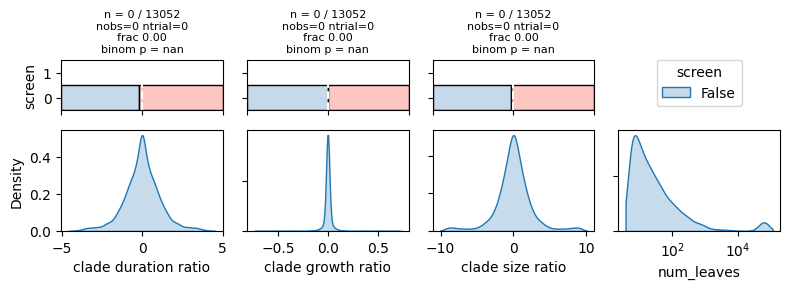

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.21212267875671387}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=5-a+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=5-a+ext=.png


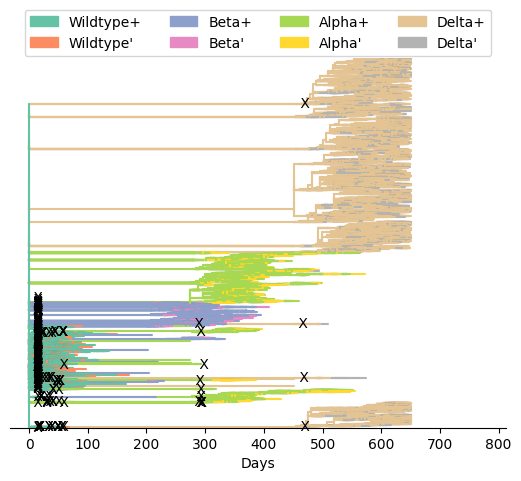

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=5-a+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=5-a+ext=.png


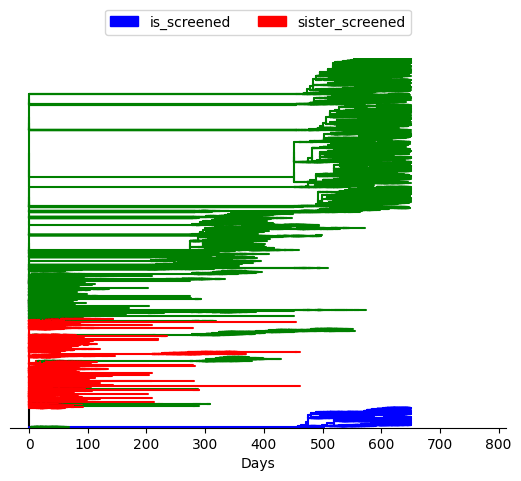

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=5-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=5-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


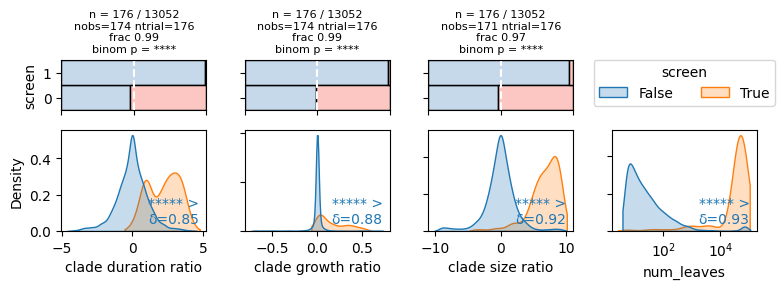

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.12114500999450684}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=6-a+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=6-a+ext=.png


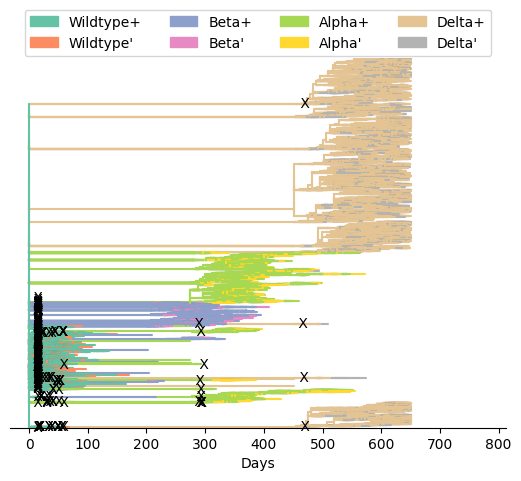

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=6-a+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=6-a+ext=.png


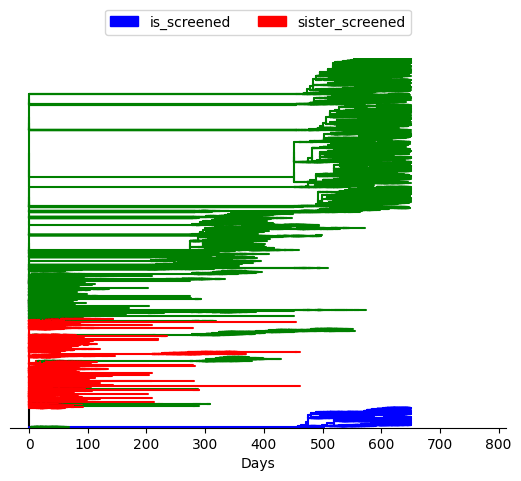

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=6-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=6-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


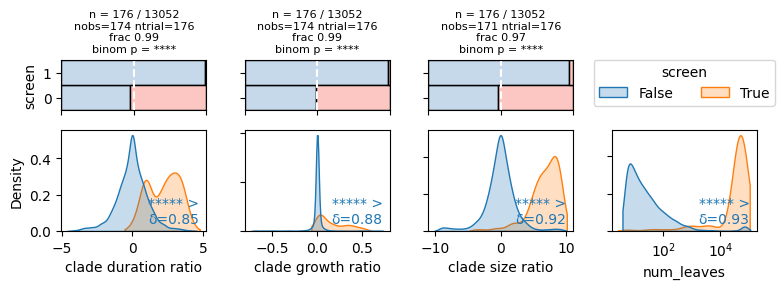

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.12735533714294434}
fisher (array([False,  True]), array([168358,    895]))
naive (array([False,  True]), array([168673,    580]))
combined (array([False,  True]), array([168749,    504]))
len(draw_df)=127566
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=7-g+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=7-g+ext=.png


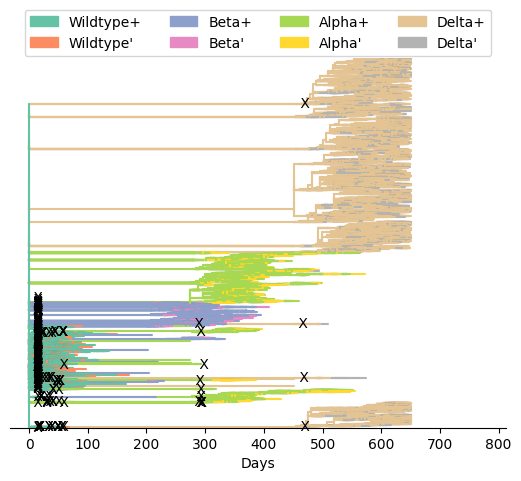

len(draw_df)=161876
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=7-g+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=7-g+ext=.png


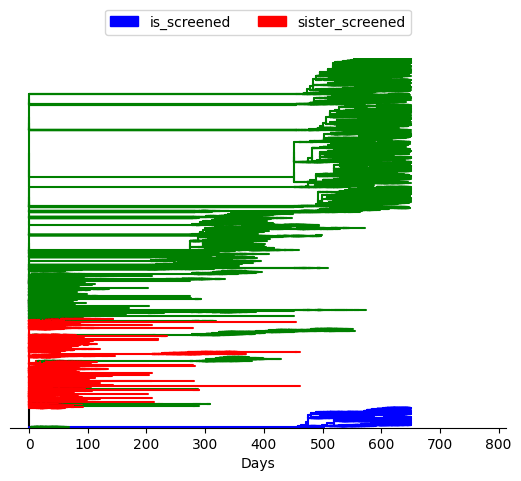

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=7-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=7-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


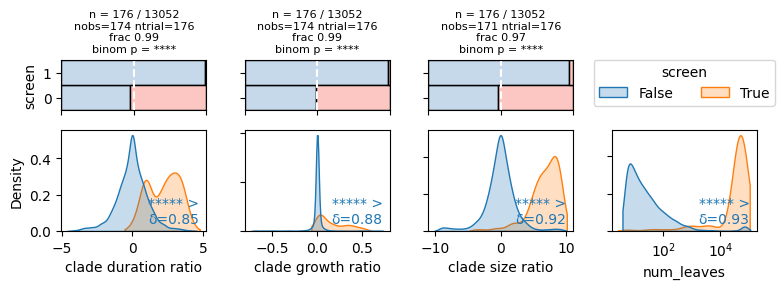

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.1848163604736328}
fisher (array([False,  True]), array([169251,      2]))
naive (array([False,  True]), array([169252,      1]))
combined (array([False,  True]), array([169252,      1]))
len(draw_df)=2
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=7-g-t+ext=.pdf
2025-04-24-dev-simuk/color=defining-mut-clades+viz=draw-biophylo+what=7-g-t+ext=.png


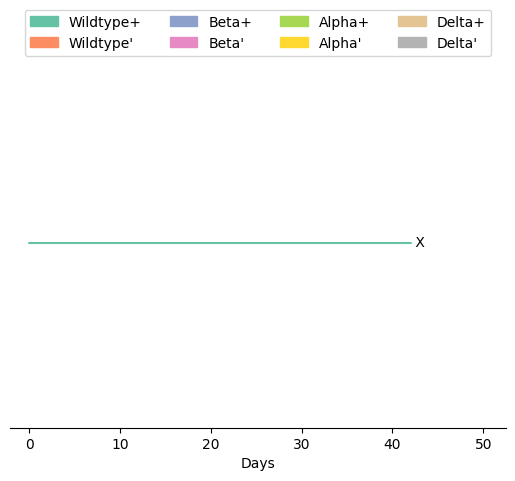

len(draw_df)=188
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=7-g-t+ext=.pdf
2025-04-24-dev-simuk/color=screened-sister+viz=draw-biophylo+what=7-g-t+ext=.png


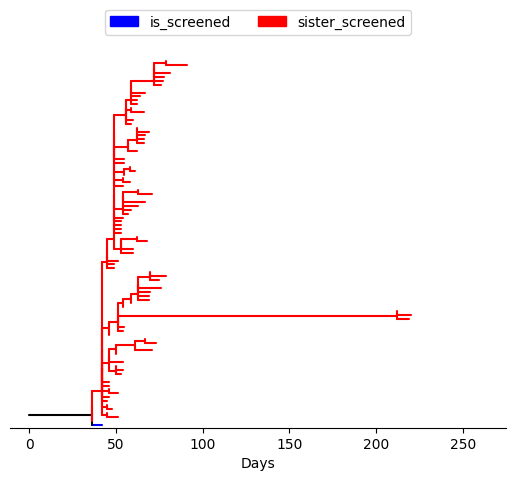

/tmp/ipykernel_5327/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_5327/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-24-dev-simuk/hue=screen+mutation=7-g-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-24-dev-simuk/hue=screen+mutation=7-g-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


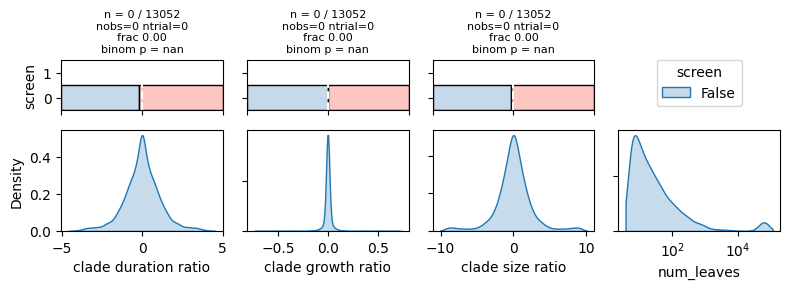

In [21]:
for mutation in it.islice(
    ((site, from_, to) for site, from_, to in mutation_masks),
    10,
):
    display(HTML(f"<h2>{mutation=}</h2>"))

    with hstrat_aux.log_context_duration(
        "screen_mutation_defined_nodes",
        logger=print,
    ):
        screen = screen_mutation_defined_nodes(
            phylo_df.copy(),
            has_mutation=mutation_masks[mutation],
        )

    print("fisher", np.unique(screen["fisher"], return_counts=True))
    print("naive", np.unique(screen["naive"], return_counts=True))
    print("combined", np.unique(screen["combined"], return_counts=True))

    draw_screened_phylo_color_by_clades(
        phylo_df.copy(), mutation=mutation, screen_result=screen
    )
    draw_screened_phylo_color_by_screened_status(
        phylo_df.copy(), mutation=mutation, screen_result=screen
    )

    data_df = phylo_df.copy()
    screen_trait_defined = "combined"
    data_df["screen"] = screen[screen_trait_defined]
    tp.tee(
        plot_screened_vs_background_distributions,
        data_df,
        min_leaves=min_leaves,
        hue="screen",
        common_norm=False,
        cut=True,
        fill=True,
        teeplot_outattrs={
            "mutation": slugify(str(mutation)),
            "screen": screen_trait_defined,
        },
        teeplot_outdir=teeplot_subdir,
    )

    plt.close("all")
    display(HTML("<hr>"))
